# Linear vortex panel method

Welcome to the final project! During this semester, I think I really learn a lot from this class. 

In lesson 11, we know how to solve the problem with constant vortex strength. This time I will make the strength linearly varying.

# Derivation of the linearly varying vortex panel method

Linearly varying vortex strength means:   
\begin{equation}
\begin{split} \gamma(x)=\gamma_{0}+\gamma_1(x-x_1)
\end{split}
\end{equation}

$γ_0$ is a constant part, and $γ_1(x-x_1)$ is the slope. By superposition, we can divide it into two parts, the constant part and varying part, and then add them together.

From lesson 11 we have already learned that the potential at location $(x, y)$ induced by an uniform flow and a vortex sheet can be represented as: 

\begin{equation}
\begin{split}
\phi(x, y) 
&= \phi_{freestream}(x, y)+ \phi_{vortex}(x, y)
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\phi(x, y) &= xU_{\infty}\cos(\alpha) + yU_{\infty}\sin(\alpha) &-
\frac{1}{2\pi} \int_{sheet} \gamma(s)\tan^{-1} (\frac{y-\eta(s)}{x-\xi(s)})ds
\end{split}
\end{equation}

$$
\begin{align*}
\phi\left(x,y\right) &= xU_{\infty}\cos(\alpha) + yU_{\infty}\sin(\alpha)- \sum_{j=1}^N \frac{1}{2\pi} \int_j\gamma_j(s) \tan^{-1} \left(\frac{y-\eta_j(s)}{x-\xi_j(s)}\right) {\rm d}s_j
\end{align*}
$$

If we discretize the sheet into $N$ panels, re-write the above equation using discretized integral. Assume $l_j$ represents the length of the panel $j$. And so that

\begin{equation}
\left\{
\begin{array}{l}
\xi_j(s)=x_j-s\sin\beta_j \\
\eta_j(s)=y_j+s\cos\beta_j
\end{array}
,\ \ \ 
0\le s \le l_j
\right.
\end{equation}

\begin{equation}
\begin{split} \gamma_j(s)=\gamma_j+(\frac{\gamma_{j+1}-\gamma_j}{l_j})s
\end{split}
\end{equation}

$$
\begin{align*}
\phi\left(x,y\right) &= xU_{\infty}\cos(\alpha) + yU_{\infty}\sin(\alpha)- \sum_{j=1}^N \frac{\gamma_j}{2\pi} \int_j \tan^{-1} \left(\frac{y-\eta_j(s)}{x-\xi_j(s)}\right) {\rm d}s_j- \sum_{j=1}^N \frac{1}{2\pi}(\frac{\gamma_{j+1}-\gamma_j}{l_j}) \int_j s\tan^{-1} \left(\frac{y-\eta_j(s)}{x-\xi_j(s)}\right) {\rm d}s_j
\end{align*}
$$

# Discretization into panels

Let's first import our favorite libraries, and the function integrate and linalg from SciPy, as in Lesson 11.

In [1]:
# import libraries and modules needed
import os
import math
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

We start by importing the NACA0012 geometry from a data file:

In [2]:
# load geometry from data file
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

Then we plot the airfoil:

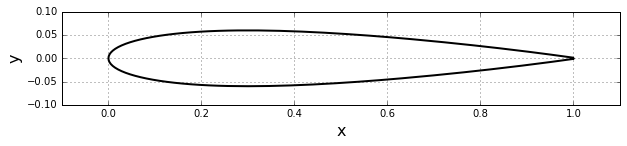

In [3]:
# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

The contour defining the airfoil will be partitioned into N panels, using the same method as in Lesson 10.

We define a class Panel that will store all information about one panel: start and end points, center point, length, orientation, tangential velocity and pressure coefficient.

In [4]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya                       # panel starting-point
        self.xb, self.yb = xb, yb                       # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'                          # upper surface
        else:
            self.loc = 'lower'                          # lower surface
        
        
        self.vt = 0.0                                   # tangential velocity
        self.cp = 0.0                                   # pressure coefficient

Like before, we call the function define_panels to discretize the airfoil geometry in N panels. The function will return a NumPy array of N objects of the type Panel.

In [5]:
def define_panels(x, y, N):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """
    
    R = (x.max()-x.min())/2.0        # circle radius
    x_center = (x.max()+x.min())/2.0 # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0*numpy.pi, N+1) # array of angles
    x_circle = x_center +  R*numpy.cos(theta)      # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)     # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends) # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

Now we can use the new function to define the geometry for the airfoil panels, and then plot the panel nodes on the geometry.

In [6]:
# discretize geoemetry into panels
N = 100                            # number of panels
panels = define_panels(x, y, N)   # discretizes of the geometry into panels

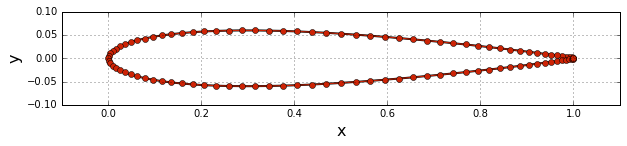

In [7]:
# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

# Freestream Condition

The airfoil is immersed in a freestream $(U_\infty$,$\alpha)$ where $U_\infty$ and $\alpha$ are the velocity magnitude and angle of attack, respectively. 

In [8]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf, alpha):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            
        alpha: float, optional
            Angle of attack in degrees;
            
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [9]:
# define freestream conditions
u_inf = 1.0                                # freestream speed
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)      # instantiation of the object freestream

# Flow tangency boundary condition

From lesson 11 we have already learned:

\begin{equation}
\left\{
\begin{array}{l}
U_n(x, y)=\frac{\partial \phi}{\partial x}(x, y) n_x(x, y)+\frac{\partial \phi}{\partial y}(x, y) n_y(x, y) \\
U_t(x, y)=\frac{\partial \phi}{\partial x}(x, y) t_x(x, y)+\frac{\partial \phi}{\partial y}(x, y) t_y(x, y)
\end{array}
\right.
\end{equation}

\begin{equation}
\left\{
\begin{array}{l}
n_x= cos(\beta_i), n_y= sin(\beta_i) \\
t_x= -sin(\beta_i), t_y= cos(\beta_i)
\end{array}
\right.
\end{equation}

So we can derive:

\begin{equation}
\left\{
\begin{array}{l}
U_n(x,y)=U_{\infty}\cos(\alpha-\beta_i)+\frac{1}{2\pi}\sum_{j=1}^N \gamma_j(\int_{j} f_j(s)ds\cos(\beta_i)-\int_{j} g_j(s)ds\sin(\beta_i))-\frac{1}{2\pi}\sum_{j=1}^N \frac{\gamma_j}{l_j}(\int_{j} sf_j(s)ds\cos(\beta_i)-\int_{j} sg_j(s)ds\sin(\beta_i))+\frac{1}{2\pi}\sum_{j=1}^N \frac{\gamma_{j+1}}{l_j}(\int_{j} sf_j(s)ds\cos(\beta_i)-\int_{j} sg_j(s)ds\sin(\beta_i)) \\
U_t(x,y)=U_{\infty}\sin(\alpha-\beta_i)+\frac{1}{2\pi}\sum_{j=1}^N \gamma_j(\int_{j} f_j(s)ds(-sin(\beta_i))-\int_{j} g_j(s)ds\cos(\beta_i))-\frac{1}{2\pi}\sum_{j=1}^N \frac{\gamma_j}{l_j}(\int_{j} sf_j(s)ds(-sin(\beta_i))-\int_{j} sg_j(s)ds\cos(\beta_i))+\frac{1}{2\pi}\sum_{j=1}^N \frac{\gamma_{j+1}}{l_j}(\int_{j} sf_j(s)ds(-sin(\beta_i))-\int_{j} sg_j(s)ds\cos(\beta_i))
\end{array}
\right.
\end{equation}

\begin{equation}
\left\{
\begin{array}{l}
f_j(s)=\frac{(y-\eta_j(s))}{(x-\xi_j(s))^2+(y-\eta_j(s))^2} \\
g_j(s)=\frac{(x-\xi_j(s))}{(x-\xi_j(s))^2+(y-\eta_j(s))^2}
\end{array}
\right.
\end{equation}

In [10]:
def integral_1(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
def integral_2(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return (s* ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [12]:
def vortex_normal_1(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    N = len(panels)
    A1 = numpy.empty((N, N), dtype=float)  
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A1, 0.)  
    # vortex contribution on a panel from others

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):                
            if i != j:
                A1[i,j] = 0.5/numpy.pi*(integral_1(p_i.xc, p_i.yc, p_j, -numpy.sin(p_i.beta),numpy.cos(p_i.beta)))
                         
    return A1

In [13]:
def vortex_normal_2(panels):
    N = len(panels)
    A2 = numpy.empty((N, N), dtype=float)          
    numpy.fill_diagonal(A2, -0.5/numpy.pi)  #value of I_2
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):    
            if i != j:
                A2[i,j] = (0.5/numpy.pi)*(1./p_j.length)*(integral_2(p_i.xc, p_i.yc, p_j, -numpy.sin(p_i.beta),numpy.cos(p_i.beta)))
                         
    return A2

In [14]:
def vortex_normal_3(panels, A2):
    N = len(panels)
    A3 = A2
                         
    return A3

In [15]:
#Let's call this functions to get A1,A2,A3.

A1 = vortex_normal_1(panels)
A2 = vortex_normal_2(panels)
A3 = vortex_normal_3(panels,A2)

# Build the matrix

Here, we build and solve the linear system of equations of the form

$$[A][\gamma] = [b]$$

When $j=0$, only A1 and A2 exist

When $0<j<N$, A1,A2,A3 exist

When $j=N$, only A3 exists

In [16]:
def A_normal(panels,A1,A2,A3):
    """Builds the normal matrix
    
    Arguments
    ---------
    panels: panels of the geometry
    A1: term related to the first integral in U_n
    A2: term related to the second integral in U_n
    A3: term related to the third integral in U_n
    
    Returns
    -------
    A_n: Nx(N+1) matrix, where N is number of panels. 
    
    """
    N = len(panels)
    A_n = numpy.zeros((N, N+1), dtype=float) 
    
    for i in range(N):
        
        A_n[i,0] = A1[i,0] - A2[i,0]
        A_n[i,-1] = A3[i,-1]
        
        for j in range(N-1):
            
            A_n[i,j+1] = A1[i,j+1] - A2[i,j+1] + A3[i,j]
    
    return A_n

# Kutta condition

Our matrix have $N+1$ columns. We need an extra row.
In this case, the Kutta condition must meet: $\gamma_0+\gamma_N=0$

In [17]:
#Kutta condition

def kutta_array(N):
    """Builds the kutta array.
    
    Arguments
    ---------
    N: number of panels
    
    Returns
    -------
    k_a -- 1D array ((N+1)x1, N is the number of panels). kutta array
    """
    k_a = numpy.zeros(N+1,dtype=float)

    k_a[0] = 1.
    k_a[-1] = 1.
    
    return k_a

In [18]:
def build_matrix(A_n, k_a, N):
    """Builds the A matrix to solve the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: Nx(N+1) matrix (N is the number of panels).
    k_a -- 1D array ((N+1)x1, N is the number of panels).
    Returns
    -------
    A_solve: (N+1)x(N+1) matrix (N is the number of panels).
    """

    #Matrix A_solve (N+1)x(N+1)

    A_solve = numpy.empty((N+1, N+1), dtype=float)
    
    A_solve[0:N,:] = A_n[:,:]
    A_solve[-1,:] = k_a[:]

    return A_solve


In [19]:
def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    freestream: farfield conditions.
    
    Returns
    -------
    b: 1D array ((N+1)x1, N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+1,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    b[-1] = 0.
    
    return b

In [20]:
N=len(panels)
#To build A
A_n =A_normal(panels,A1,A2,A3)
k_a = kutta_array(N)

#Putting all together to get A
A = build_matrix(A_n, k_a, N)

#RHS
b = build_rhs(panels, freestream)

In [21]:
# solves the linear system
gammas = linalg.solve(A, b)

# Surface pressure coefficient

In [22]:
def vortex_tangential_1(panels):
    
    """
    Build matrix coefficients associated with the first
    integral in U_t ---> (B_1)
    """

    N = len(panels)
    B1 = numpy.empty((N, N), dtype=float)          
    numpy.fill_diagonal(B1, -0.5)

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):                
            if i != j:
                B1[i,j] = 0.5/numpy.pi*(integral_1(p_i.xc, p_i.yc, p_j,-numpy.cos(p_i.beta), -numpy.sin(p_i.beta)))
                         
    return B1

In [23]:
def vortex_tangential_2(panels):
    """
    Build matrix coefficients associated with the first
    integral in U_t ---> (B_2)
    """
    N = len(panels)
    B2 = numpy.empty((N, N), dtype=float)          
    numpy.fill_diagonal(B2, -0.25)

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):                
            if i != j:
                B2[i,j] = 0.5/numpy.pi*(1./p_j.length)*(integral_2(p_i.xc, p_i.yc, p_j,-numpy.cos(p_i.beta), -numpy.sin(p_i.beta)))
                        
    return B2

In [24]:
def vortex_tangential_3(panels, B2):
    """
    Build matrix coefficients associated with the first
    integral in U_t ---> (B_3)
    """
    N = len(panels)
    B3 = B2
                         
    return B3

In [25]:
#Let's call this functions to get B1,B2,B3.
B1 = vortex_tangential_1(panels)
B2 = vortex_tangential_2(panels)
B3 = vortex_tangential_3(panels,B2)

In [26]:
def A_tangential(panels,B1,B2,B3):
    """Builds the tangential matrix
    
    Arguments
    ---------
    panels: panels of the geometry
    B1: term related to the first integral in U_t
    B2: term related to the second integral in U_t
    B3: term related to the third integral in U_t
    
    Returns
    -------
    A_t: Nx(N+1) matrix, where N is number of panels. 
    """
    N = len(panels)
    A_t = numpy.zeros((N, N+1), dtype=float) 
    
    for i in range(N):
        
        A_t[i,0] = B1[i,0] - B2[i,0]
        A_t[i,-1] = B3[i,-1]
        
        for j in range(N-1):
            
            A_t[i,j+1] = B1[i,j+1] - B2[i,j+1] + B3[i,j]
    
    return A_t

In [27]:
A_t = A_tangential(panels,B1,B2,B3)

In [28]:
#The vector associated with the free-stream for U_t

b_t = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])

In [29]:
U_t = numpy.dot(A_t, gammas) + b_t

In [30]:
for i, panel in enumerate(panels):
        panel.vt = U_t[i]

In [31]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels: array of panels.
    freestream: farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [32]:
get_pressure_coefficient(panels, freestream)

In [33]:
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
print(voverVsquared)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]


In [34]:
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100
print(xtheo)

[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


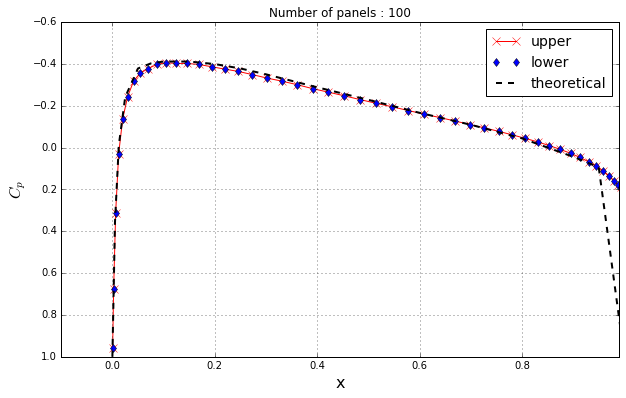

In [35]:
# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 0.99)
pyplot.ylim(1.0, -0.6)
pyplot.title('Number of panels : %d' % N);

In [36]:
# defines and creates the object freestream
u_inf = 1.0                                # freestream speed
alpha = 10.0                                # angle of attack (in degrees)
freestream_10 = Freestream(u_inf, alpha)      # instantiation of the object freestream

In [37]:
b_10 = build_rhs(panels, freestream_10)

In [38]:
gammas_10 = linalg.solve(A, b_10)

In [39]:
#The vector associated with the free-stream for U_t

b_t_10 = freestream.u_inf * numpy.sin([freestream_10.alpha - panel.beta for panel in panels])

In [40]:
#Getting the tangential velocity
U_t_10 = numpy.dot(A_t, gammas_10) + b_t_10

In [41]:
for i, panel in enumerate(panels):
        panel.vt = U_t_10[i]

In [42]:
get_pressure_coefficient(panels, freestream_10)

In [50]:
x_exp , Cp_exp = numpy.loadtxt('CP_Gregory_expdata.dat', dtype=float, delimiter=' ', unpack=True)

ValueError: could not convert string to float: b'variables="x/c","cp"'

NameError: name 'x_exp' is not defined

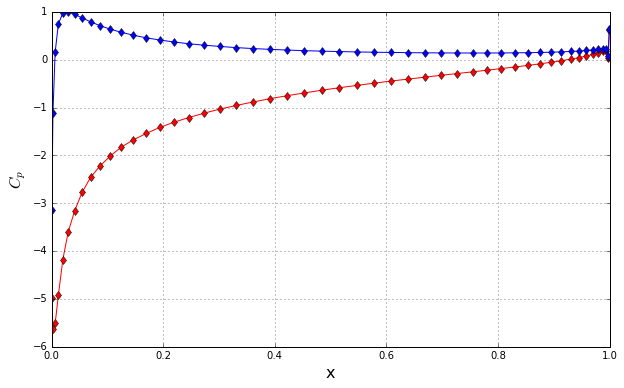

In [47]:
# plots the surface pressure coefficient

val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
cp_min, cp_max = min( panel.cp for panel in panels ), max( panel.cp for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'], 
         [panel.cp for panel in panels if panel.loc == 'upper'], 
         color='r', linewidth=1, marker='d', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'], 
         [panel.cp for panel in panels if panel.loc == 'lower'], 
         color='b', linewidth=1, marker='d', markersize=6)

pyplot.plot(x_exp,Cp_exp,color='g', linewidth=0, marker='D', markersize=8, markeredgecolor='g',
markerfacecolor='None', markeredgewidth=1.5)

pyplot.legend(['upper face', 'lower face', 'Gregory exp_data (upper face)'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Angle of attack 10 deg, Number of panels : %d' % N, fontsize=20)
#pyplot.savefig('CP_10.pdf'); add this line to save fig;

In [ ]:
def get_lift(freestream, Np):
    """
    Get the lift coefficient for a number of panels Np
    """
    #define panels
    panels = define_panels(Np)
    
    #coefficients to build A
    A1 = coeff_1_normal(panels)
    A2 = coeff_2_normal(panels)
    A3 = coeff_3_normal(panels,A2)
    
    #To build A
    A_n =A_normal(panels,A1,A2,A3)
    k_a = kutta_array(Np)

    #Putting all together to get A
    A = build_matrix(A_n, k_a, Np)

    #RHS
    b = build_rhs(panels, freestream)

    # solves the linear system
    gammas = linalg.solve(A, b)
    
    #Coefficients to get A_tangential.
    B1 = coeff_1_tangential(panels)
    B2 = coeff_2_tangential(panels)
    B3 = coeff_3_tangential(panels,B2)
    
    #A_tangential
    A_t = A_tangential(panels,B1,B2,B3)
    
    #The vector associated with the free-stream for U_t
    b_t = freestream.U_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])

    #Get tangential velocity
    U_t = numpy.dot(A_t, gammas) + b_t
    
    for i, panel in enumerate(panels):
        panel.vt = U_t[i]
    
    #Get Cp
    get_pressure_coefficient(panels, freestream)
    
    L = 0.
    for panel in panels:
        L -= panel.cp*panel.length*numpy.sin(panel.beta)
    
    return L

In [ ]:
L_np=[]
Np_list=[20,40,60,80,100,120,140,160,180,200, 400]
for i in Np_list:
    L_np.append(get_lift(freestream_10, i))

In [ ]:
L_exp = 1.2219

#Relative error

rel_err = []
for i in L_np:
    rel_err.append(numpy.abs(L_exp - i)/L_exp)

#Percentage error

per_err = []
for i in rel_err:
    per_err.append(100.*i)

In [ ]:
#Plotting
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('Np', fontsize=16)
pyplot.ylabel('error $\%$', fontsize=16)
pyplot.xlim(10, 210)
pyplot.ylim(3, 8)
pyplot.xticks(numpy.linspace(10, 210, 21)) 
pyplot.yticks(numpy.linspace(2, 8, 17))

pyplot.title('Percentage error vs number of panels', fontsize=20)

pyplot.plot(Np_list, per_err,color='r', linewidth=0, marker='o', markersize=6);
#pyplot.savefig('error.pdf'); add this line to save fig;

In [ ]:
#For Np=400 the precentage error is:
L_400_err = per_err[-1]

print ('L_400_err = %.4f' %L_400_err)